In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [ ]:
classes = [
    str(x) for x in range(10)
]  # A list of class names in str for the dataset. (Digits 0 - 9)

# preprocessing
# chose a random rotation and perspective transformation to add more variety and samples to the dataset.
# opted to have a random rotation of 45 degrees as to not 'mix' digits 6 and 9.
# opted not to add flips as the inverted digits are invalid.
transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.RandomRotation(degrees=45),
        v2.RandomPerspective(),
    ]
)

# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data", train=True, download=True, transform=transforms
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=v2.Compose([v2.PILToTensor(), v2.ToDtype(torch.float32, scale=True)]),
)

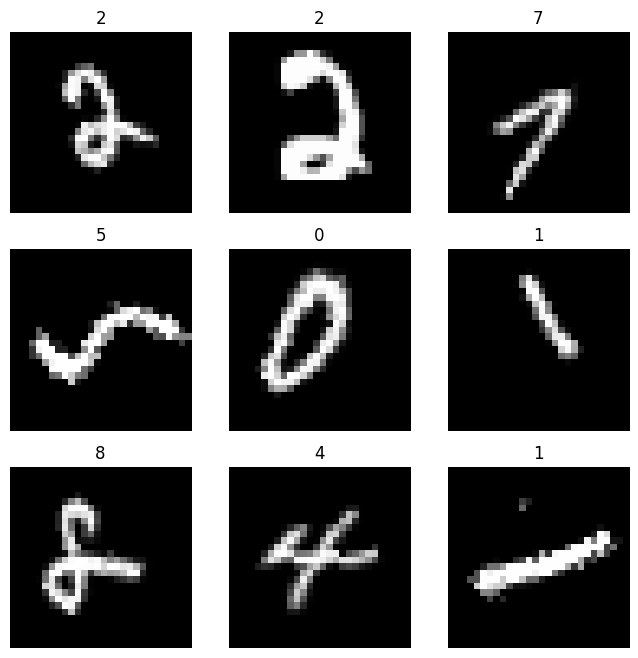

In [3]:
# show a 3 x 3 grid of random samples from the training data

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(v2.ToPILImage()(img), cmap="gray")
plt.show()

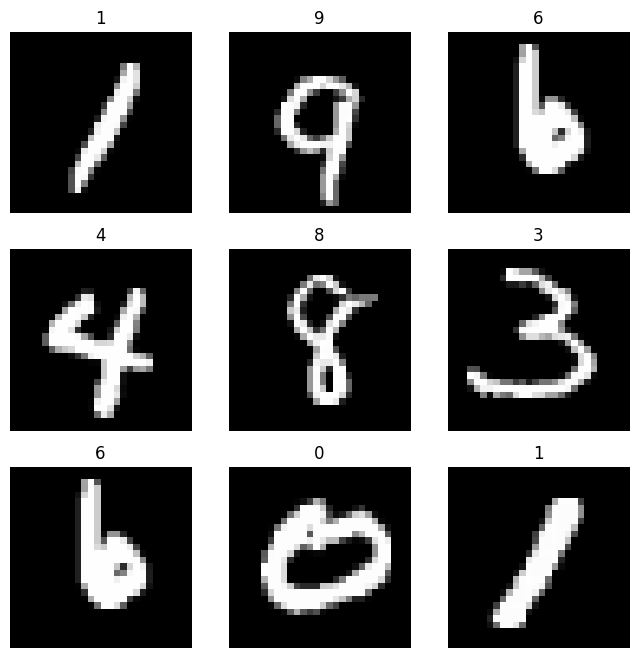

In [4]:
# show a 3 x 3 grid of random samples from the test data

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(v2.ToPILImage()(img), cmap="gray")
plt.show()

In [5]:
# Batch size based from PyTorch Docs
# has now been modified to 128 based from https://arxiv.org/abs/1711.00489
# where a similar learning curve may be achieved with a larger batch size as opposed to decreasing the learning rate.
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")  # images of digits
    #             (N) Batch Size, (C)hannels, (H)eight, (W)idth
    print(f"Shape of y: {y.shape} {y.dtype}")  # labels of image
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
# nn obtained from trial and error
from nn import NeuralNetwork

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
# use adam optimizer for faster convergence (attempted SGD initially)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train() and test() funcs obtained from PyTorch Docs

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [10]:
# opted for 16 epochs due to model converging at around this amount.
epochs = 16
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309624  [  128/60000]
loss: 1.174583  [12928/60000]
loss: 0.787685  [25728/60000]
loss: 0.624251  [38528/60000]
loss: 0.671019  [51328/60000]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.218876 

Epoch 2
-------------------------------
loss: 0.427458  [  128/60000]
loss: 0.490646  [12928/60000]
loss: 0.298650  [25728/60000]
loss: 0.505912  [38528/60000]
loss: 0.324200  [51328/60000]
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.119882 

Epoch 3
-------------------------------
loss: 0.253457  [  128/60000]
loss: 0.341058  [12928/60000]
loss: 0.345093  [25728/60000]
loss: 0.340936  [38528/60000]
loss: 0.542140  [51328/60000]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.094278 

Epoch 4
-------------------------------
loss: 0.312413  [  128/60000]
loss: 0.398665  [12928/60000]
loss: 0.265279  [25728/60000]
loss: 0.257162  [38528/60000]
loss: 0.270335  [51328/60000]
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.098305 

Epoch 5
------------------------

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [5]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

Test Data Len: 10000
Predicted: "6", Actual: "5"
Predicted: "6", Actual: "4"
Predicted: "8", Actual: "9"
Predicted: "0", Actual: "6"
Predicted: "9", Actual: "4"
Predicted: "0", Actual: "8"
Predicted: "2", Actual: "8"
Predicted: "8", Actual: "1"
Predicted: "3", Actual: "7"
Predicted: "7", Actual: "4"
Predicted: "2", Actual: "7"
Predicted: "9", Actual: "7"
Predicted: "5", Actual: "3"


KeyboardInterrupt: 

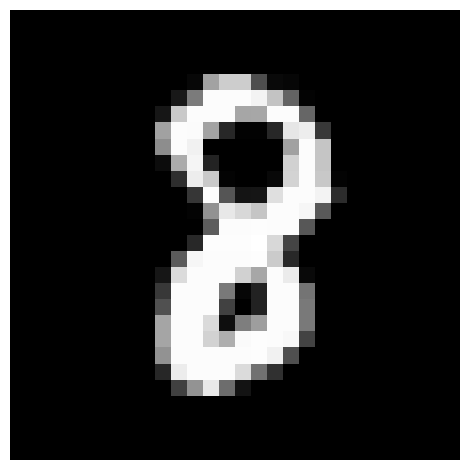

In [6]:
# Perform a Quick Test on the Test Dataset
import torchshow as ts

model.eval()
fail = 0

print("Test Data Len: " + str(len(test_data)))

for x, y in test_data:
    with torch.no_grad():
        x = x.to(device)
        ts.save(x)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        if predicted != actual:
            print(f'Predicted: "{predicted}", Actual: "{actual}"')
            fail += 1

print("Tests:" + str(len(test_data) - fail) + "/" + str(len(test_data)) + " OK")